Interface the Image Container object with Tensorflow models
===========================================================

In this tutorial, we show how you can use the Image Container object to train a resnet model to predict cluster labels of spots.

This is a general approach that can be easily extended to a variety of supervised, self-supervised or unsupervised tasks. We aim to highlight how the flexibility provided by the image container, and it's seamles integration with **AnnData**, makes it easy to interface your data with modern deep learning frameworks such as **Tensorflow**.

Furthermore, we show how you can leverage such resent model to generate a new set of feature that can provided useful insights on spots similarity based on image morphology. 

First, we'll load some libraries. Note that Tensorflow is not a dependency of Squidpy and you'd therefore have to install it separately in your conda environemnt. Have a look at [here](https://www.tensorflow.org/install). This of course apply to any deep learning framework of choice.

In [1]:
import scanpy as sc
import squidpy as sq
from squidpy.im import ImageContainer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData
from sklearn.model_selection import (
    train_test_split,
)  # we'll use this function to split our dataset in train and test set
import tensorflow as tf
from tensorflow.keras.layers.experimental import (
    preprocessing,
)  # let's use the new pre-processing layers for reisizing and data augmentation tasks

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tensorflow=={tf.__version__}")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.20.0 scipy==1.6.0 pandas==1.1.4 scikit-learn==0.24.1 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2
squidpy==0.0.0
tensorflow==2.3.0


We will load the public data available in Squidpy.

In [2]:
adata = sq.datasets.visium_hne_adata()
img = sq.datasets.visium_hne_image()

Create train-test split
-----------------------
We then need to create a vector of our labels with which to train the classifier. In this case, we will train a classifier to predict cluster labels obtained from gene expression. We'll create a one hot encoder array with the convenient function `tf.one_hot`. Furthermore, we'll split the vector indices to get a train and test set. Note that we specify the cluster labels as `stratify` argument, to make sure that the cluster labels are balanced in each split. 

In [3]:
# get train,test split stratified by cluster labels
train_idx, test_idx = train_test_split(
    adata.obs_names.values,
    test_size=0.2,
    stratify=adata.obs["cluster"],
    shuffle=True,
    random_state=42,
)

In [4]:
print(
    f"Train set : \n {adata[train_idx, :].obs.cluster.value_counts()} \n \n Test set: \n {adata[test_idx, :].obs.cluster.value_counts()}"
)

Train set : 
 Cortex_1                         227
Thalamus_1                       209
Cortex_2                         206
Cortex_3                         195
Fiber_tract                      181
Hippocampus                      178
Hypothalamus_1                   166
Thalamus_2                       154
Cortex_4                         131
Striatum                         122
Hypothalamus_2                   106
Cortex_5                         103
Lateral_ventricle                 84
Pyramidal_layer_dentate_gyrus     54
Pyramidal_layer                   34
Name: cluster, dtype: int64 
 
 Test set: 
 Cortex_1                         57
Thalamus_1                       52
Cortex_2                         51
Cortex_3                         49
Fiber_tract                      45
Hippocampus                      44
Hypothalamus_1                   42
Thalamus_2                       38
Cortex_4                         33
Striatum                         31
Hypothalamus_2             

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Create the Tensorfow Datasets
-----------------------------

Next, we'll create a tensorflow dataset which will be used as data loader for model training. A key aspect of this step is how the Image Container makes it easy to relate spots information to the underlying image.
In particular, we will make use of `img.generate_spot_crops()`, a method that creates a generator to crop the tissue image corresponding to each spot. 
In just one line of code you can create this generator as well as specifying the size of the crops . You might want to increase the size to include some neighborhood morphology information. 

We won't get too much in details of the additional arguments and steps realted to the Tensorflow Dataset objects, you can familiarize youreself with tensorflow datasets [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [5]:
def get_ohe(adata: AnnData, cluster_key: str, obs_names: np.ndarray):
    cluster_labels = adata[obs_names, :].obs["cluster"]
    classes = cluster_labels.unique().shape[0]
    cluster_map = {v: i for i, v in enumerate(cluster_labels.cat.categories.values)}
    labels = np.array([cluster_map[c] for c in cluster_labels], dtype=np.uint8)
    labels_ohe = tf.one_hot(labels, depth=classes, dtype=tf.float32)
    return labels_ohe


def create_dataset(
    adata: AnnData,
    img: ImageContainer,
    obs_names: np.ndarray,
    cluster_key: str,
    augment: bool,
    shuffle: bool,
):
    # image dataset
    spot_generator = img.generate_spot_crops(
        adata,
        obs_names=obs_names,  # this arguent specified the observations names
        scale=1.5,  # this argument specifies that we will consider some additional context under each spot. Scale=1 would crop the spot with exact coordinates
        as_array="image",  # this line specifies that we will crop from the "image" layer. You can specify multiple layers to obtain crops from multiple pre-processing steps.
        return_obs=False,
    )
    image_dataset = tf.data.Dataset.from_tensor_slices([x for x in spot_generator])

    # label dataset
    lab = get_ohe(adata, cluster_key, obs_names)
    lab_dataset = tf.data.Dataset.from_tensor_slices(lab)

    ds = tf.data.Dataset.zip((image_dataset, lab_dataset))

    if shuffle:  # if you want to shuffle the dataset during training
        ds = ds.shuffle(1000, reshuffle_each_iteration=True)
    ds = ds.batch(64)  # batch
    processing_layers = [
        preprocessing.Resizing(128, 128),
        preprocessing.Rescaling(1.0 / 255),
    ]
    augment_layers = [
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(0.8),
    ]
    if augment:  # if you want to augment the image crops during training
        processing_layers.extend(augment_layers)

    data_processing = tf.keras.Sequential(processing_layers)

    ds = ds.map(lambda x, y: (data_processing(x), y))  # add processing to dataset
    return ds

In [6]:
train_ds = create_dataset(adata, img, train_idx, "cluster", augment=True, shuffle=True)
test_ds = create_dataset(adata, img, test_idx, "cluster", augment=True, shuffle=True)

Here, we are actually instantiating the model. We'll use a pre-trained resnet on imagenet, and a Dense layer for output. 

In [7]:
input_shape = (128, 128, 3)  # input shape
inputs = tf.keras.layers.Input(shape=input_shape)

# load Resnet with pre-trained imagenet weights
x = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    classes=15,
    pooling="avg",
)(inputs)
outputs = tf.keras.layers.Dense(
    units=15,  # add output layer
)(x)
model = tf.keras.Model(inputs, outputs)  # create model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # add optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # add loss
)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 15)                30735     
Total params: 23,618,447
Trainable params: 23,565,327
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    verbose=2,
)

Epoch 1/50
34/34 - 10s - loss: 2.1171 - val_loss: 3.5322
Epoch 2/50
34/34 - 8s - loss: 1.1931 - val_loss: 6.7173
Epoch 3/50
34/34 - 9s - loss: 0.8442 - val_loss: 9.0895
Epoch 4/50
34/34 - 9s - loss: 0.6472 - val_loss: 9.9287
Epoch 5/50
34/34 - 9s - loss: 0.5563 - val_loss: 20.7174
Epoch 6/50
34/34 - 9s - loss: 0.4584 - val_loss: 14.3775
Epoch 7/50
34/34 - 9s - loss: 0.3577 - val_loss: 22.0802
Epoch 8/50
34/34 - 9s - loss: 0.3227 - val_loss: 26.9401
Epoch 9/50
34/34 - 9s - loss: 0.2151 - val_loss: 16.7383
Epoch 10/50
34/34 - 9s - loss: 0.1891 - val_loss: 12.8635
Epoch 11/50
34/34 - 9s - loss: 0.1793 - val_loss: 11.3826
Epoch 12/50
34/34 - 9s - loss: 0.1490 - val_loss: 16.0750
Epoch 13/50
34/34 - 9s - loss: 0.1197 - val_loss: 12.5656
Epoch 14/50
34/34 - 9s - loss: 0.1188 - val_loss: 9.1868
Epoch 15/50
34/34 - 9s - loss: 0.1081 - val_loss: 18.4093
Epoch 16/50
34/34 - 9s - loss: 0.0855 - val_loss: 31.8823
Epoch 17/50
34/34 - 9s - loss: 0.0766 - val_loss: 15.1988
Epoch 18/50
34/34 - 9s - lo

We can plot training and test loss during training. Clearly it would require some fine-tuning :)

<AxesSubplot:ylabel='loss'>

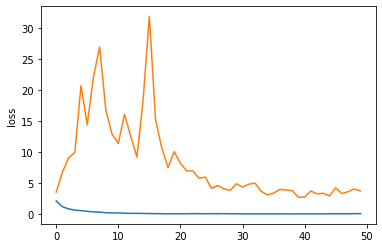

In [11]:
sns.lineplot(x=np.arange(50), y="loss", data=history.history)
sns.lineplot(x=np.arange(50), y="val_loss", data=history.history)

What we are actually interesting is the the resnet embedding values of the dataset after training. We expect that such embedding have learnt relevant features for the image that can be used for downstream analysis such as clustering or integration with gene expression.

For generating this embedding, we first create a new dataset, that contains the full list of spots, in the correct order and without augmentation.

In [12]:
full_ds = create_dataset(
    adata, img, adata.obs_names.values, "cluster", augment=False, shuffle=False
)

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Then, we instantiate another model without the output layer, in order to get the final embedding layer.

In [13]:
model_embed = tf.keras.Model(inputs, x)
embedding = model_embed.predict(full_ds)

We can then save such embedding in a new AnnData, and copy over all the relevant metadata from the AnnData with gene expression counts...

In [14]:
adata_resnet = AnnData(embedding, obs=adata.obs.copy())
adata_resnet.obsm["spatial"] = adata.obsm["spatial"].copy()
adata_resnet.uns = adata.uns.copy()
adata_resnet

AnnData object with n_obs × n_vars = 2688 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'spatial'

... perform the standard clustering analysis.

In [15]:
sc.pp.scale(adata_resnet)
sc.pp.pca(adata_resnet)
sc.pp.neighbors(adata_resnet)
sc.tl.leiden(adata_resnet, key_added="resnet_embedding_cluster")
sc.tl.umap(adata_resnet)

Interestingly, it seems that despite the poor performance on the test set, the model has encoded some information relevant to separate spots from each other. Such clustering annotation also resembled the original annotation based on gene expression similarity.

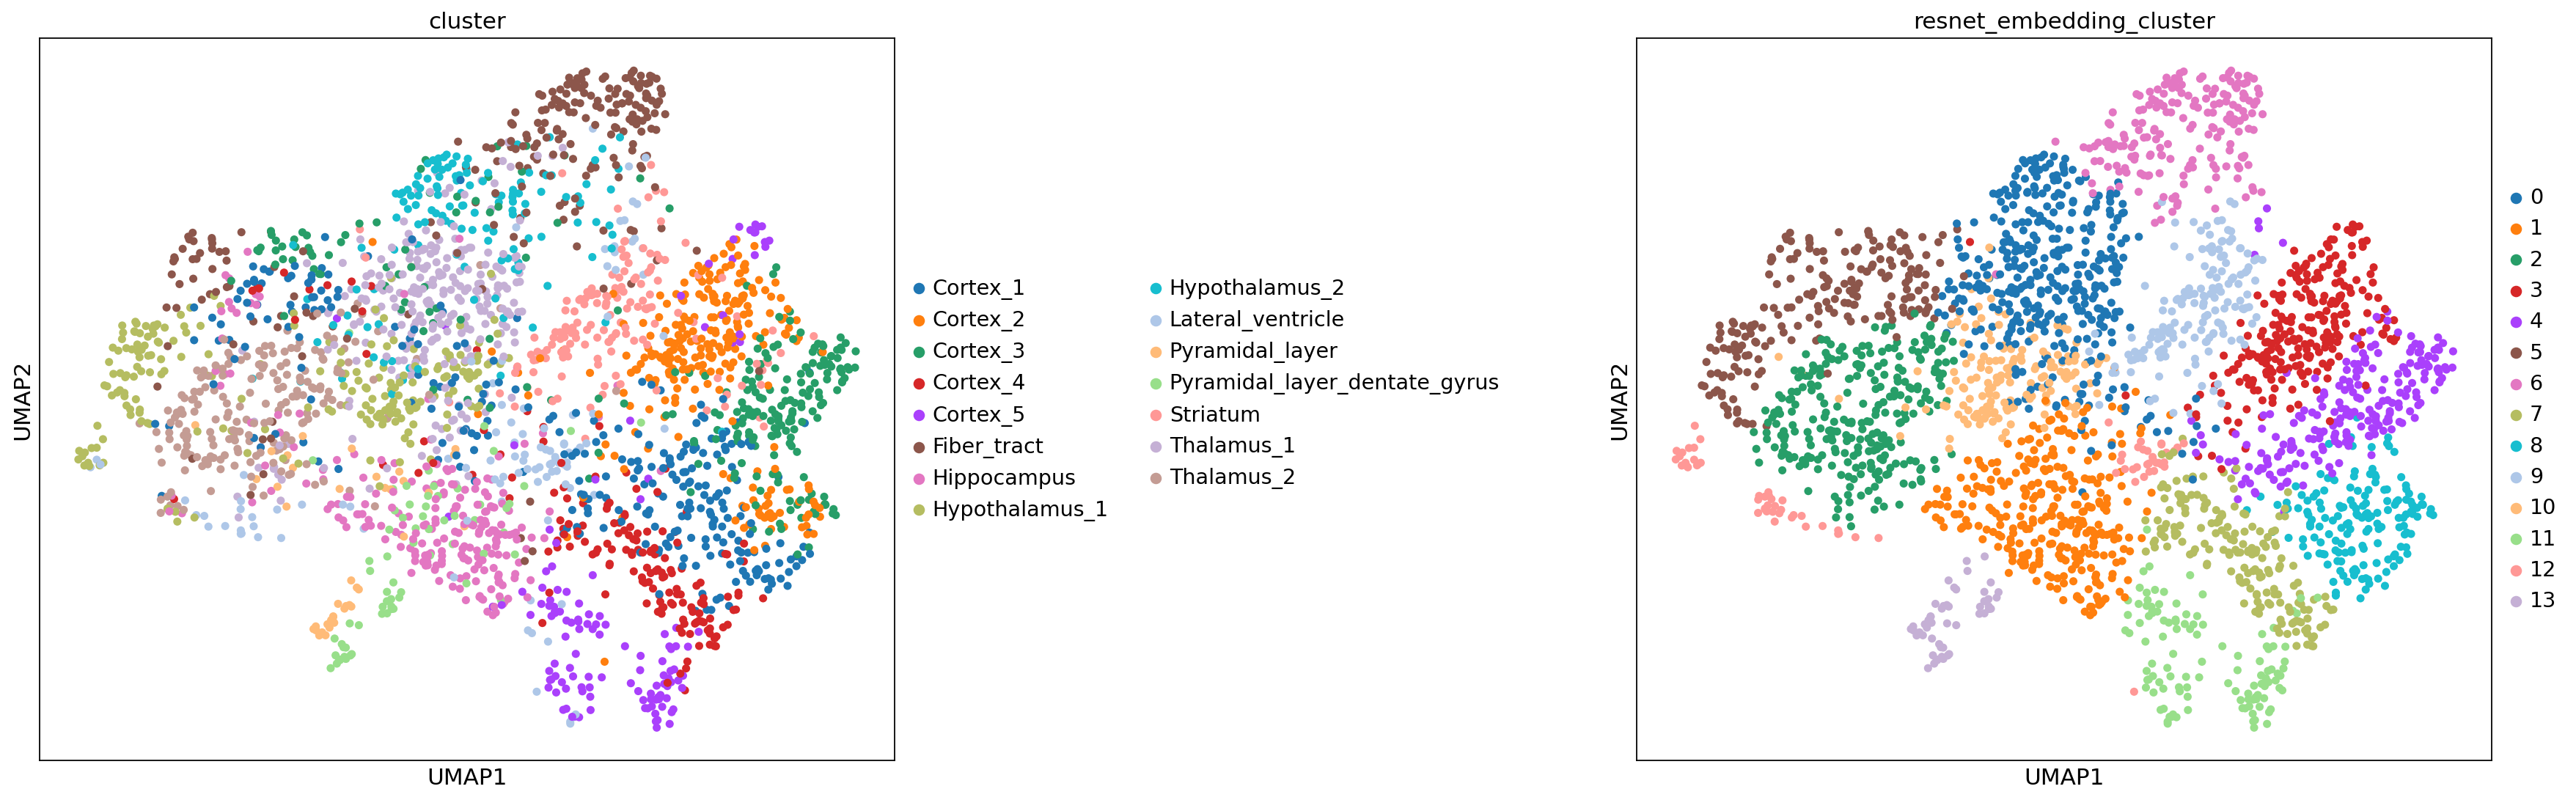

In [16]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.umap(
    adata_resnet, color=["cluster", "resnet_embedding_cluster"], size=100, wspace=0.7
)

We can visualize the same information in spatial coordiantes. Again some clusters seems to closely recapitulate the Hippocampus and Pyramidal layers clusters. It seems to have worked suprisingly well!

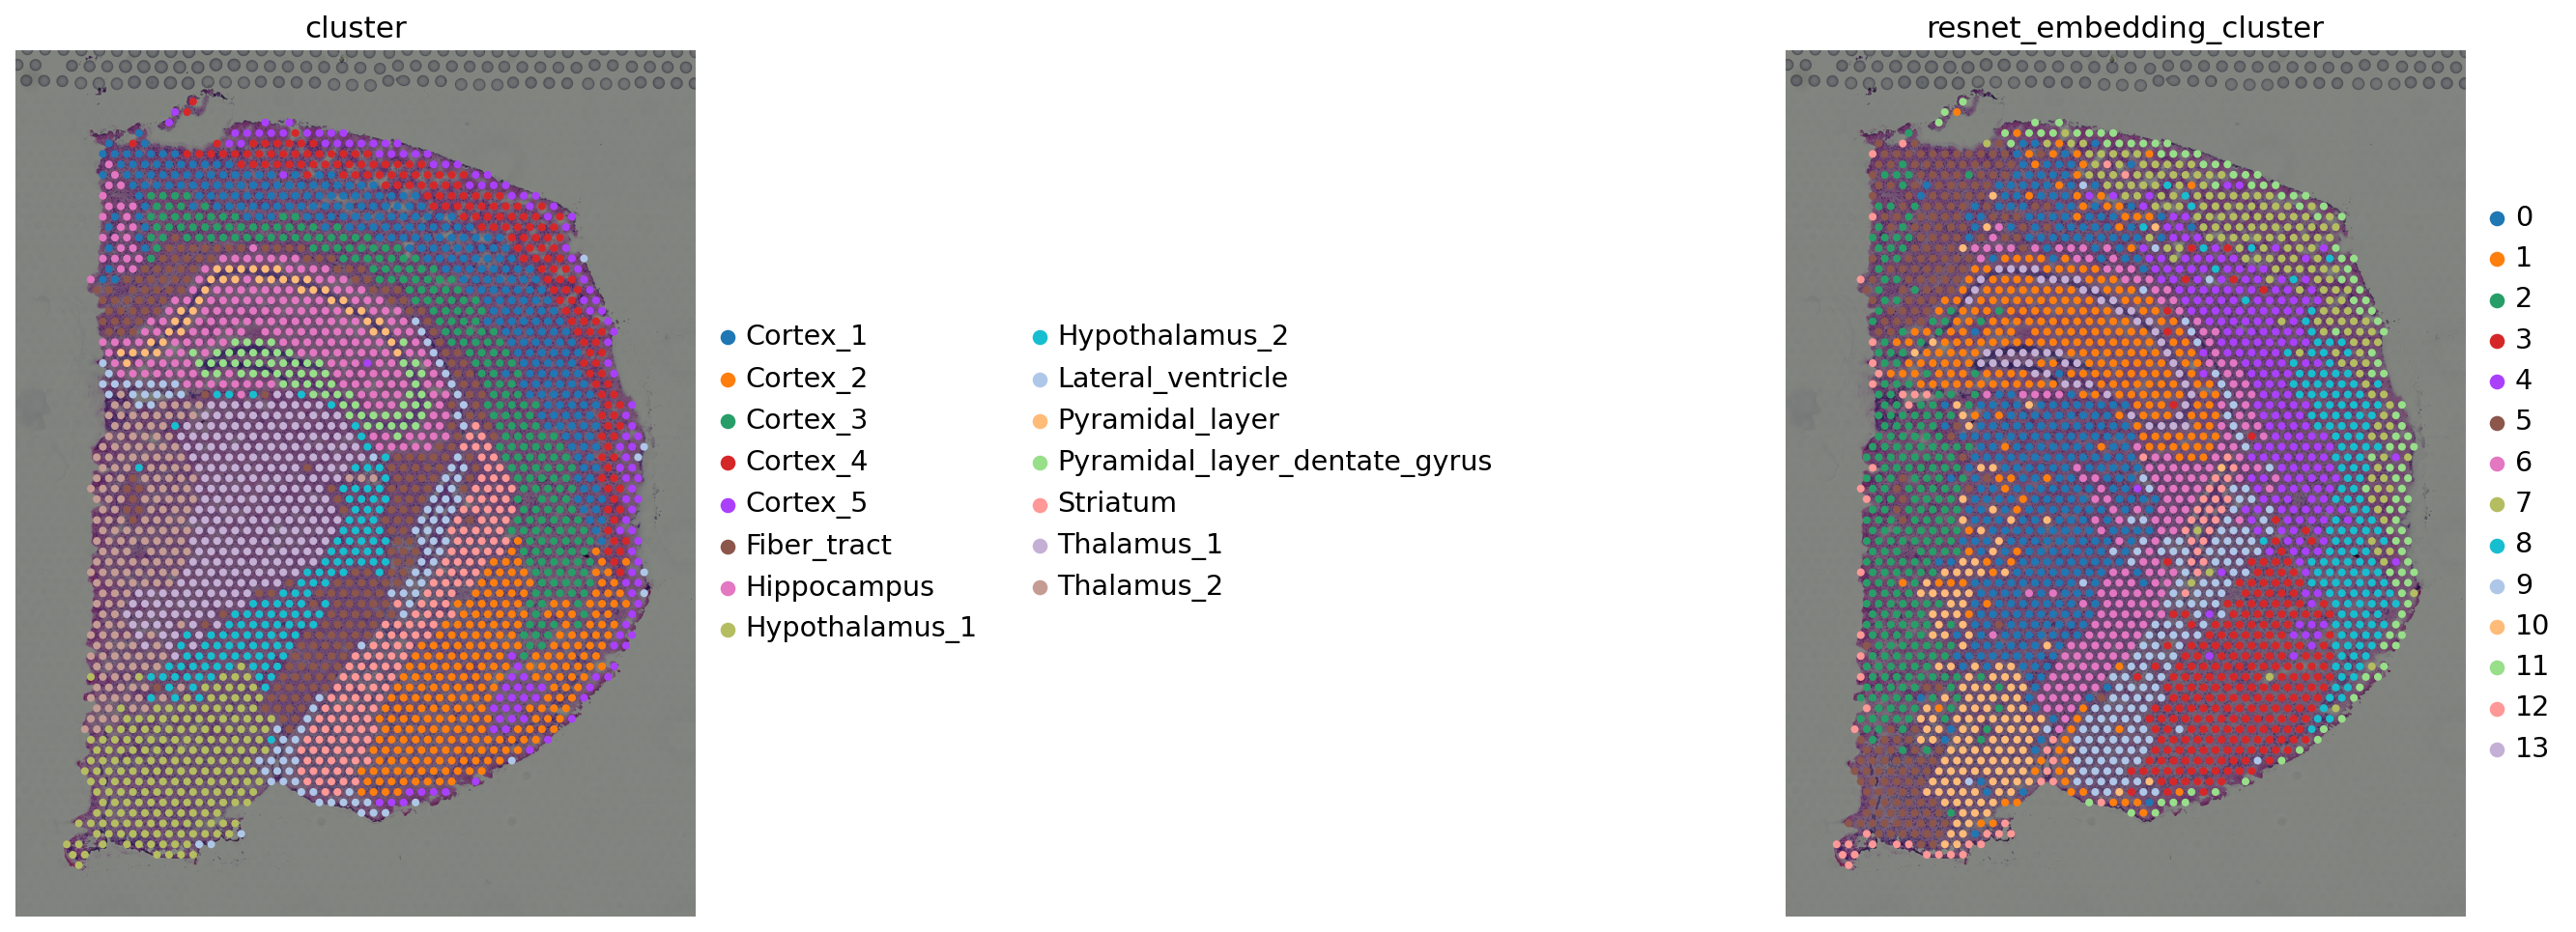

In [17]:
sc.pl.spatial(
    adata_resnet,
    color=["cluster", "resnet_embedding_cluster"],
    frameon=False,
    wspace=0.5,
)

An additional analysis could be to integrate information of both gene expression and the features learnt by the resnet classifier, in order to get a joint representation of both gene expression and image information. Such integration could be done for instance by concatenating the resulting PCA from the gene expression `adata` and the resnet embedding `adata_resnet`. After concatenating the principal components, you could follow the usual steps of building a knn graph and clusteing with the leiden algorithm. 

Wit this tutorial we have shown how to interface the Squidpy workflow with modern deep learning framework, and have inspired you with additional analysis that leverage several data modalitied and powerful DL-based representations.